# HW 3 - Open Source Energy System Modelling 

by Antonia Golab

The following script uses the baseline scenario from "westeros_baseline.ipynb"- tutorial by IIASA as a starting point and introduces a gas power plant - in particular a natural gas combined cycle power plant to the scenario.

For this, the following assumptions were made about this power plant: The lifetime of the power plant is assumed to be 25 (1,2). Following a case study by EIA (2), investment costs are estimated to be 1,084 $/ kW (see case 8 in report), fixed costs 14.10 USD/kW per year and variable ones 2.55 USD/MWh = 22.338 USD/kWa. It is assumed that the power plant emitts up to 3.144 tCO2/kWa (3) which is a value applicable for NGCC power plants without carbon capture. 

In the initial electricity mix, the gas power plant is assumed to produce 1/3 of the demanded electricity.

It is important to note here that none of initial parameters describing lifetime and costs of the coal and wind power plants were manipulated. Therefore, their validity and wether these are over- or underestimated compared to real-life systems is not checked. 

The further goal is to obtain carbon pricings which allow an energy system where the usage of coal, wind and gas for electricity generation at the same time is present.

All observations will be made within the bounded period of the model (years 700-720). </br>

This _jupyter notebook_ script is structured in the following way: </br>

1. Introduction of gas power plant  </br>
2. Calculation of initial carbon prices for sensitivity analysis  </br>
3. Sensitivity Analysis  </br>
3.2. Scenario A: Lower carbon prices  </br>
3.3. Scenario B: Higher carbon prices  </br>
3.4. Scenario C: Declining carbon prices  </br>
3.5. Scenario D: Peak Carbon price in 710  </br>
3.5. Scenario E: Drop in carbon price 710  </br>
4. Final discussion </br>

References: 

(1) Singh, B., Strømman, A. H., & Hertwich, E. (2011). Life cycle assessment of natural gas combined cycle power plant with post-combustion carbon capture, transport and storage. International Journal of Greenhouse Gas Control, 5(3), 457-466.

(2) https://www.eia.gov/analysis/studies/powerplants/capitalcost/pdf/capital_cost_AEO2020.pdf, last access May 31th, 2021.

(3) Rubin, E. S., Rao, A. B., & Chen, C. (2005). Comparative assessments of fossil fuel power plants with CO2 capture and storage. In Greenhouse gas control technologies 7 (pp. 285-293). Elsevier Science Ltd.


## 1. Introduction of gas power plant

In this step, the gas power plant is introduced to the baseline scenario with parameters describing lifetime and costs as previously described. 

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'westeros_with_gasppl','introducing gas power plant',
                  keep_solution=False)
scen.check_out()

In [3]:
country = 'Westeros'
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

In [4]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_output = make_df(base, node_dest=country, time_dest='year')

In [5]:
scen.add_set("technology", ['gas_ppl'])
gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity', 
                   level='secondary', value=1., unit="GWa")
scen.add_par('output', gas_out)

In [6]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

capacity_factor = {
    'gas_ppl': 1,
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scen.add_par('capacity_factor', df)

In [7]:
model_horizon = [700, 710, 720]

base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [8]:
lifetime = {
    'gas_ppl': 25,   # LIFETIME: 25 years
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scen.add_par('technical_lifetime', df)

In [9]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [10]:
growth_technologies = [
    "gas_ppl"
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1) 
    scen.add_par('growth_activity_up', df)

In [11]:
history = [690]

base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

In [12]:
demand_per_year = 40 * 12 * 1000 / 8760
grid_efficiency = 0.9

historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 1/3
gas_fraction = 1/3


old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': (1 - (coal_fraction + gas_fraction)) * historic_generation,
    'gas_ppl': gas_fraction * historic_generation
}


for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scen.add_par('historical_activity', df)

In [13]:
act_to_cap = {
    'gas_ppl': 1 / 10 / capacity_factor['gas_ppl'] / 2, 
     'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, 
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scen.add_par('historical_new_capacity', df)

In [14]:
# in $ / kW (specific investment cost)
costs = {
    'gas_ppl': 1084    # INVESTEMENT COSTS: 1,084 USD
 
}
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}
for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scen.add_par('inv_cost', df)

In [15]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    'gas_ppl': 14.10     # FIXED O&M costs = 14.10 USD/kW per year
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scen.add_par('fix_cost', df)

In [16]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}


costs = {
    'gas_ppl': 2.55,    # VARIABLe O&M costs = 2.55 USD/kWa
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scen.add_par('var_cost', df)
    
scen.add_set('emission', 'CO2')
scen.add_cat('emission', 'GHG', 'CO2')

base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

# value for coal_ppl is taken from westeros_emissions_bounds - tutorial
emission_factor = make_df(base_emission_factor, technology= 'coal_ppl', emission= 'CO2', value = 7.4)
scen.add_par('emission_factor', emission_factor)
emission_factor = make_df(base_emission_factor, technology= 'gas_ppl', emission= 'CO2', value = 3.144 )
scen.add_par('emission_factor', emission_factor)

INFO:root:unit `tCO2/kWa` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


In [17]:
scen.commit(comment='introducing gas power plant')
scen.set_as_default()

In [18]:
scen.solve()

In [19]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

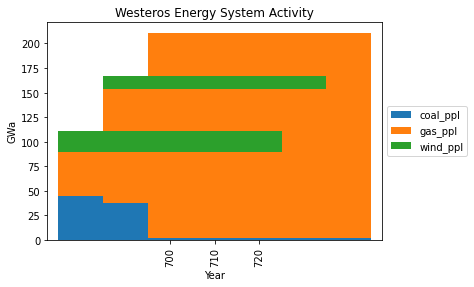

In [20]:
rep.set_filters(t=["coal_ppl", "wind_ppl","gas_ppl"])
rep.get("plot activity")

In [21]:
mp.close_db()

The plot above displays the projected activities of power plants after introducing the gas power plant given a cost-minimal solution. 

The assumption of no emissions will be referred to as  __"Scenario 0.A"__ throughout this text.

## 2. Calculation of initial carbon prices for sensitivity analysis  

To introduce carbon prices to system next, carbon prices are calculated to serve as a starting point. They are obtained by imposing emission bound - similar as in the "westeros_emission_bounds.ipynb" tutorial which is used here as a template.

### 2.1. Introduction of emissions

In [22]:
mp = ixmp.Platform()
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='westeros_with_gasppl')
scen = base.clone(model, 'westeros_with_emissionbound','introducing gas power plant',
                  keep_solution=False)
scen.check_out()

As there are no studies suggesting a CO2 budget for Westeros, the emission bound of 500MtCO2 is used here, following the same procedure as the "westeros_emissions_bounds" - tutorial.

In [23]:
scen.add_par('bound_emission', [country, 'GHG', 'all', 'cumulative'],
             value=500., unit='MtCO2')

In [24]:
scen.commit(comment='introducing emissions and setting an upper bound')
scen.set_as_default()

In [25]:
scen.solve()

In [26]:
mp.close_db()

In [27]:
mp = ixmp.Platform()
model = 'Westeros Electrified'

scen_bd = message_ix.Scenario(mp, model=model, scenario='westeros_with_emissionbound')
emissions = scen_bd.var('EMISS', {'node': 'Westeros'})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,471.763722,0.0
1,Westeros,CO2,all,710,447.608784,0.0
2,Westeros,CO2,all,720,580.627494,0.0


In [28]:
emission_prices = scen_bd.var('PRICE_EMISSION')
emission_prices.set_index('year').lvl

year
700    20.705702
710    33.727407
720    54.938391
Name: lvl, dtype: float64

In [29]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_bd)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

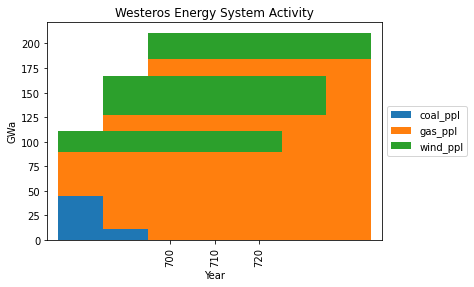

In [30]:
rep.set_filters(t=["coal_ppl", "wind_ppl","gas_ppl"])
rep.get("plot activity")

In [31]:
mp.close_db()

To achieve the given upper bound emissions in year 720, the following carbon pricing is suggested: 

In [32]:
emission_prices.set_index('year').lvl

year
700    20.705702
710    33.727407
720    54.938391
Name: lvl, dtype: float64

These prices are now used as a starting point for a sensitivity analysis with the focus on the effect of the developement of carbon prices on projected acitivities of the different kinds of power plants. The upper bound scenario calculated here will be referred to as __"Scenario 0.B"__. 

## 3. Sensitivity Analysis

### 3.1. Scenario A: Lower carbon prices

In the first scenario carbon prices are lowered by a factor of 50. This "extreme" decrease of prices is made to inspect how very low carbon prices effect the activities.


In [33]:
emission_prices_A = emission_prices.set_index('year').lvl/40
emission_prices_A = [3] * 3

In [34]:
mp = ixmp.Platform()
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='westeros_with_gasppl')
scen_a = base.clone(model, 'westeros_scenA','introducing gas power plant',
                  keep_solution=False)
scen_a.check_out()

In [35]:
base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': emission_prices_A
}

tax_emission = make_df(base_tax_emission)
scen_a.add_par('tax_emission', tax_emission)
scen_a.par('tax_emission')

scen_a.commit(comment='adapt_1')
scen_a.set_as_default()

scen_a.solve()

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

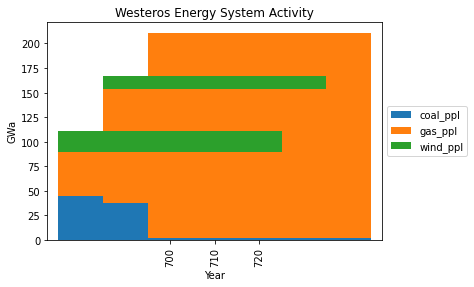

In [36]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_a)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl","gas_ppl"])
rep.get("plot activity")

In [37]:
mp.close_db()

The result of this scenario resembles Scenario 0.A (see Section 1) where emissions are not regarded. Here, the emission prices are very low and seem to have no effect on the electricity generation.

### 3.2. Scenario B: Higher carbon taxes

In increasing the carbon prices, the expectation is that wind power plant production would increase significantly. The approach of modelling an extreme is continued here by multiplying the initial carbon prices by 50. 

In [38]:
emission_prices_B= emission_prices.set_index('year').lvl * 50
emission_prices_B

year
700    1035.285096
710    1686.370331
720    2746.919570
Name: lvl, dtype: float64

In [39]:
mp = ixmp.Platform()
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='westeros_with_gasppl')
scen_b = base.clone(model, 'westeros_scenB','introducing gas power plant',
                  keep_solution=False)
scen_b.check_out()

In [40]:
base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': emission_prices_B
}

tax_emission = make_df(base_tax_emission)
scen_b.add_par('tax_emission', tax_emission)
scen_b.par('tax_emission')

scen_b.commit(comment='adapt_1')
scen_b.set_as_default()

scen_b.solve()


<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

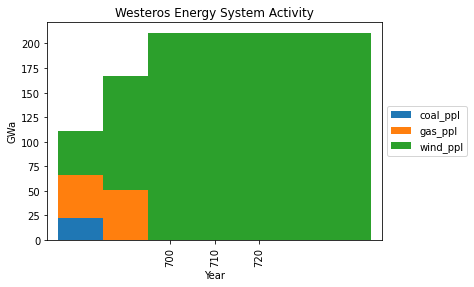

In [41]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_b)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl","gas_ppl"])
rep.get("plot activity")

In [42]:
mp.close_db()

The inital expectation is fulfilled here. It is visible that already in year 700 only electricity from wind power plants is produced.

### Scenario C: Declining carbon prices

For scenario C, the assumption is a declination of carbon prices between the years 700, 710 and 720. For this, simply the order of the initial carbon prices is reversed.

In [43]:
emission_prices_C = list(emission_prices.set_index('year').lvl)[::-1]
emission_prices_C

[54.93839140600808, 33.727406612358095, 20.70570192688487]

In [44]:
mp = ixmp.Platform()
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='westeros_with_gasppl')
scen_c = base.clone(model, 'westeros_scenC','introducing gas power plant',
                  keep_solution=False)
scen_c.check_out()

In [45]:
base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': emission_prices_C
}

tax_emission = make_df(base_tax_emission)
scen_c.add_par('tax_emission', tax_emission)
scen_c.par('tax_emission')

scen_c.commit(comment='adapt_1')
scen_c.set_as_default()

scen_c.solve()

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

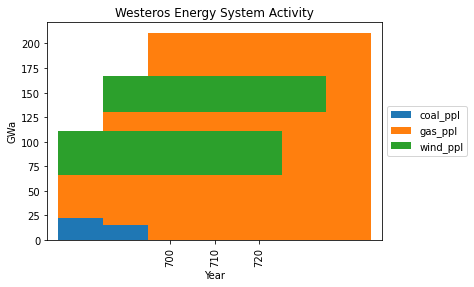

In [46]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_c)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl","gas_ppl"])
rep.get("plot activity")

In [47]:
mp.close_db()

The declining carbon prices seem to cause an overall higher activity of wind power plants. 

### Scenario D: Peak Carbon price in 710

In scenarios D and E, the effect of extreme fluactions of the carbon prices will be analysed. First, an extreme peak of carbon price in 710 is assumed. 

In [48]:
emission_prices_D = [emission_prices.set_index('year').lvl[700], emission_prices.set_index('year').lvl[710]*50, emission_prices.set_index('year').lvl [720]]
emission_prices_D

[20.70570192688487, 1686.3703306179048, 54.93839140600808]

In [49]:
mp = ixmp.Platform()
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='westeros_with_gasppl')
scen_d = base.clone(model, 'westeros_scenD','introducing gas power plant',
                  keep_solution=False)
scen_d.check_out()

In [50]:
base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': emission_prices_D
}

tax_emission = make_df(base_tax_emission)
scen_d.add_par('tax_emission', tax_emission)
scen_d.par('tax_emission')

scen_d.commit(comment='adapt_1')
scen_d.set_as_default()

scen_d.solve()

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

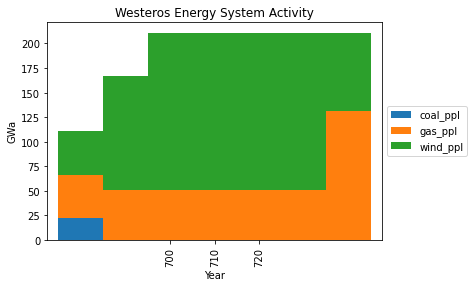

In [51]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_d)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl","gas_ppl"])
rep.get("plot activity")

In [52]:
mp.close_db()

The extreme peak in 710 causes huge activities of wind power plants but also constant electricity production by gas power plants while electricity from coal similarly declines as in Scenario B.

### Scenario E: Drop in carbon price 710

Finally, a scenario in which the carbon price drops in 710 is calculated. For this, it is assumed that given the initial carbon prices, the carbon price drops to 0 in year 710.

In [53]:
emission_prices_E = [emission_prices.set_index('year').lvl[700], 0, emission_prices.set_index('year').lvl [720]]
emission_prices_E

[20.70570192688487, 0, 54.93839140600808]

In [54]:
mp = ixmp.Platform()
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='westeros_with_gasppl')
scen_e = base.clone(model, 'westeros_scenE','introducing gas power plant',
                  keep_solution=False)
scen_e.check_out()

In [55]:
base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': emission_prices_E
}

tax_emission = make_df(base_tax_emission)
scen_e.add_par('tax_emission', tax_emission)
scen_e.par('tax_emission')

scen_e.commit(comment='adapt_1')
scen_e.set_as_default()

scen_e.solve()

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

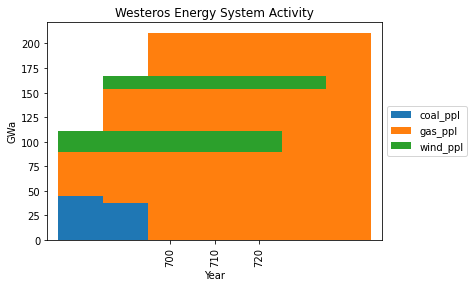

In [56]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_e)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl","gas_ppl"])
rep.get("plot activity")

In [57]:
mp.close_db()

A drop to seems to effect the energy mix less than a sudden extreme rise in the carbon price. Though, it is important to note here that the absolute difference to the initial carbon prices is higher in Scenario D than in Scenario E. 

## 4. Final Discussion


Overall, it is evident that the activity of coal power plants tends to decline in the presence of gas power plants. The advantage might be due to two reasons: Firstly, the emission factor of gas power plants (NGCCs) is approximatly half of the one of coal power plants. Secondly, the lifetime of gas power plants is five years longer. In the presence of carbon prices, coal power plants are mostly affected. Therefore, only Scenario 0.A where emissions are neglected and Scenario A for which very low carbon prices are assumed project continous activity of all power generation. Therefore, a so-called "sweet spot" for carbon prices such that coal, wind and gas are used at the same time would be close to 0 USD/tCO2. 

A simple sensitivity analysis assuming a constant carbon price is performed in the following where from 0 on, the price was increased slowly by 1 USD/tCO2 to observe what the highest possible carbon price could be that would allow the acitivity for all three power plant types. The upper bound was found to be 3 USD/tCO2.

In [58]:
emission_prices_sweet_spot = [3] * 3

In [59]:
mp = ixmp.Platform()
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='westeros_with_gasppl')
scen_f = base.clone(model, 'westeros_scenD','introducing gas power plant',
                  keep_solution=False)
scen_f.check_out()

In [60]:
base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': emission_prices_sweet_spot
}

tax_emission = make_df(base_tax_emission)
scen_f.add_par('tax_emission', tax_emission)
scen_f.par('tax_emission')

scen_f.commit(comment='adapt_1')
scen_f.set_as_default()

scen_f.solve()

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

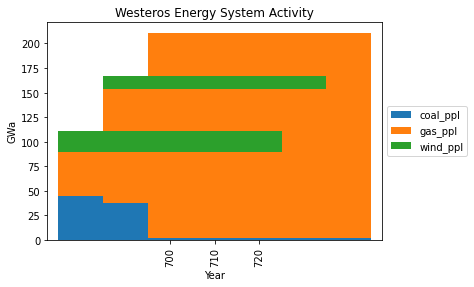

In [61]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_f)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl","gas_ppl"])
rep.get("plot activity")

In [62]:
mp.close_db()